# In this notebook, we show the steps taken to analyze and compare the feature spaces originated from the **genes** dataset. Additionally, the shap library is developed to explore the importance of the different features.







*Related Links:*

https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel

https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b

https://shap.readthedocs.io/en/latest/index.html

### Imports section: 


In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/Drive', force_remount=True)

Mounted at /content/Drive


In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression, Lasso
import matplotlib.pyplot as plt
from xlwt import Workbook
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import os
from pandas_profiling import ProfileReport
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from datetime import datetime
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')
! pip freeze
! pip install --upgrade scikit-learn # set the version of the scikit learn library to obtain same results of previous experiments and Convergence

In [ ]:
# Current working directory and other paths
cwd = os.getcwd()
print(cwd)
!cd Drive/
path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/data/" ### <- insert here path to retrieve data
results_path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/results/" ### <- insert here path to save results

# Dataset with gene expression 
gene_dataset = pd.read_csv(path+"gene_expression_data_and_metadata/data_mrna_seq_v2_rsem.txt" , index_col= 0 , sep='\t') 
gene_dataset = gene_dataset.transpose() # (818, 20440)
# remove first column about entrez_gene_id
gene_dataset = gene_dataset.iloc[1: , :]
print(gene_dataset.shape)
# Training and Testing datasets
training_ds =  pd.read_excel(path+"train_test_new.xlsx", sheet_name="train_new")
testing_ds = pd.read_excel(path+"train_test_new.xlsx", sheet_name="test_new")

/content
(817, 20440)


In [ ]:
# feature spaces 
pam_fs =  pd.read_csv(path+"gene_expression_data_and_metadata/PAM50.txt" , index_col= 0 , sep='\t') 
limma_fs =  pd.read_csv(path+"gene_expression_data_and_metadata/LIMMA50.txt" , index_col= 0 , sep='\t') 

pam_fs.reset_index(inplace=True)
limma_fs.reset_index(inplace=True)

### create the cpm

In [ ]:
cpm_dataset_1 = gene_dataset.div(gene_dataset.sum(axis=1), axis=0)
cpm_dataset_end = cpm_dataset_1 * 1000000
cpm_dataset = cpm_dataset_end

cpm_dataset.columns.name = ''
cpm_dataset.index.rename('sample_id', inplace=True)
cpm_dataset.index = cpm_dataset.index.str[: -3] # removal of -01 from cpm sample id which is not relevant for recognition
cpm_dataset.head()

(817, 20440)

##### filtering the genes that have expression data at the beginning lower than 4 for more than 80% of the samples.

In [ ]:
y = (gene_dataset[gene_dataset < 4].count() /818 > 0.8)
y = y[y==True]
y = y.reset_index()
gene_dataset.drop(y[''], axis=1, inplace=True)
cpm_dataset.drop(y[''], axis=1, inplace=True)

##### Evaluation of the median values

In [ ]:
med = cpm_dataset.median()
med.sort_values(inplace=True)
md = pd.DataFrame(med)
md.describe()

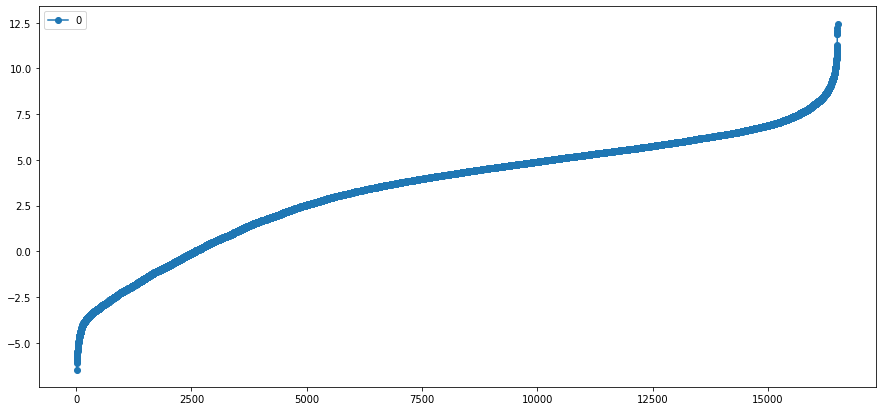

In [ ]:
%matplotlib inline
log_md = np.log2(md)
log_md.reset_index(drop=True).plot(figsize=(15,7), style='o-')

In [ ]:
md = md[md>3.38]
md.dropna(inplace=True)
gene_to_keep_by_median = md.index.tolist()
# keeping just the filtered by removing the ones with median value lower than the 25% from the describe
cpm_dataset = cpm_dataset[np.intersect1d(cpm_dataset.columns, gene_to_keep_by_median)]

### Data extraction and preprocessing

In [ ]:
def extract_and_reduce_by_columns(full_df, nofeats_ds, preproc_strategy: str= "none"): 
  """
     Function to extract dataset and a specific group of its columns.

     path: the path where to get the data values (isoforms)
     sheet_name: the excel sheet were to get the columns to select for the data (isoforms)
     nofeats_ds: the dataset without the additional columns
     name: 'trainingset' or 'testingset' for the excel 
     preproc_strategy: which preprocessing strategy to apply to the ds

  """
  full_df = full_df # path of subdatset 
  full_list= full_df['Genes'].values.tolist()  #exatrct the list of isoforms names as list
  if preproc_strategy == 'loge':
    # https://stackoverflow.com/questions/49538185/purpose-of-numpy-log1p
    log_cpm_dataset = np.log1p(cpm_dataset)
    data = log_cpm_dataset[np.intersect1d(log_cpm_dataset.columns, full_list)]
  elif preproc_strategy == 'log2':
    log_cpm_dataset = np.log2(cpm_dataset + 1) # constant added to avoid reaching zero
    data = log_cpm_dataset[np.intersect1d(log_cpm_dataset.columns, full_list)]
  elif preproc_strategy == 'normperrow':
    # normalize per rows
    data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]
    data = data.div(data.sum(axis=1), axis=0) # ----> preprocessing scaling step to try, not working
  elif preproc_strategy == 'none':
    data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]  # find the mutual isoform between main datset and subdatset 
    
  
  #data.reset_index(inplace=True) # todo remove
  #data.rename(columns={ data.columns[0]: "sample_id" }, inplace = True) 
  # print("hello", data.index)
  x = nofeats_ds['sample_id'].values.tolist()
  data1= data.loc[data.index.isin(x)]
  # print("hello11", data1)
  result = pd.merge(data1, nofeats_ds, on='sample_id')
  result
  result.rename(columns={'sample_label':'subtype'}, inplace=True )
 
  # result.to_csv(name +".csv", index=False) # save as csv file 
  return result

### Download of all datasets with different preprocessing strategies and feature spaces

In [ ]:
# List of feature space name 
feature_space_files =["FEATURE_SPACE6(MAIN)", "FEATURE_SPACE1(PAM)", "FEATURE_SPACE2(PAM)","FEATURE_SPACE1(LIMMA)","FEATURE_SPACE2(LIMMA)", "FEATURE_SPACE7(pamsimilarity)","FEATURE_SPACE8(limmasimilarity)"]

DATASET with PAM50 Feature Space 

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(pam_fs, training_ds, 'none') 
# print("aloha", train)
X_train_pam = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam = train.subtype
print("X_train size:", X_train_pam.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(pam_fs, testing_ds,'none' ) 
X_test_pam = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam = test.subtype
print("X_test size:", X_test_pam.shape)

X_train size: (410, 49)
X_test size: (127, 49)


DATASET with LIMMA50 Feature Space

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(limma_fs, training_ds, 'none' ) 
X_train_limma = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma =train.subtype
print("X_train size:", X_train_limma.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(limma_fs, testing_ds, 'none') 
X_test_limma = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma = test.subtype
print("X_test size:", X_test_limma.shape)

X_train size: (410, 185)
X_test size: (127, 185)


DATASET with PAM50 Feature Space and LOG2 PREPROCESSING

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(pam_fs, training_ds, 'log2') 
X_train_pam_log2 = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam_log2 =train.subtype
print("X_train size:", X_train_pam_log2.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(pam_fs, testing_ds, 'none') 
X_test_pam_log2 = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam_log2 = test.subtype
print("X_test size:", X_test_pam_log2.shape)

X_train size: (410, 49)
X_test size: (127, 49)


DATASET with LIMMA50 Feature Space and LOG2 PREPROCESSING

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(limma_fs, testing_ds, 'log2') 
X_train_limma_log2 = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma_log2 =train.subtype
print("X_train size:", X_train_limma_log2.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(limma_fs, testing_ds, 'log2') 
X_test_limma_log2 = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma_log2 = test.subtype
print("X_test size:", X_test_limma_log2.shape)

X_train size: (127, 185)
X_test size: (127, 185)


#### lasso feature selection from initial feature space

In [ ]:
from scipy.optimize.optimize import main
main_filtered_gene_fs = pd.DataFrame({'Genes': cpm_dataset.columns.tolist()})

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(main_filtered_gene_fs, training_ds, 'log2') 
X_train_lasso = train.drop(["sample_id","subtype"],  axis = 1)
samples_train = train.sample_id
Y_train_lasso=train.subtype
print("X_train size:", X_train_lasso.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(main_filtered_gene_fs, testing_ds,  'log2') 
X_test_lasso = test.drop(["sample_id","subtype"], axis = 1)
Y_test_lasso = test.subtype
print("X_test size:", X_test_lasso.shape)

X_train size: (410, 12385)
X_test size: (127, 12385)


In [ ]:
# Commented code to generate the feature space
# sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
# sel_.fit(X_train_lasso,Y_train_lasso)
# sel_.get_support()
# selected_feat = X_train_lasso.columns[(sel_.get_support())]

In [ ]:
# print('total features: {}'.format((X_train_lasso.shape[1])))
# print('selected features: {}'.format(len(selected_feat)))
# print('coefficients shrank to zero: {}'.format(
#      np.sum(sel_.estimator_.coef_ == 0)))
# perc_feat_selected = np.sum(sel_.estimator_.coef_ == 0)/ (49740*5)
# print(perc_feat_selected)

total features: 12385
selected features: 785
coefficients shrank to zero: 60874
0.2447687977482911


In [ ]:
# export saved feature spaces and use it to reproduce experiments
selected_feat = pd.read_csv(path+"/genesfs/lasso900.csv", index_col=0,skiprows=1, names=['gene_id'])
selected_feat = selected_feat['gene_id'].tolist()

In [ ]:
X_train_lasso = X_train_lasso[selected_feat].copy()
Y_train_lasso = Y_train_lasso

X_test_lasso = X_test_lasso[selected_feat].copy()
Y_test_lasso = Y_test_lasso

In [ ]:
# Uncomment to save feature space
# pd.DataFrame(X_train_lasso.columns).to_csv(path+"/genesfs/lasso900.csv")

## MRMR

In [ ]:
train = extract_and_reduce_by_columns(main_filtered_gene_fs, training_ds, 'log2') 
X_train_49kfs = train.drop(["sample_id","subtype"],  axis = 1)
samples_train = train.sample_id
Y_train_49kfs=train.subtype
print("X_train size:", X_train_49kfs.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(main_filtered_gene_fs,  testing_ds,  'log2') 
X_test_49kfs = test.drop(["sample_id","subtype"], axis = 1)
Y_test_49kfs = test.subtype
print("X_test size:", X_test_49kfs.shape)

# X_train_49kfs.drop(columns=X_train_49kfs.columns[X_train_49kfs.columns.duplicated()], inplace=True)
# X_test_49kfs.drop(columns=X_test_49kfs.columns[X_test_49kfs.columns.duplicated()], inplace=True)

print("X_train size:", X_train_49kfs.shape)
print("X_test size:", X_test_49kfs.shape)

X_train size: (410, 12385)
X_test size: (127, 12385)
X_train size: (410, 12385)
X_test size: (127, 12385)


In [ ]:
! pip install mrmr_selection
import mrmr
# select top K features using mRMR
from mrmr import mrmr_classif

setting number of features to select to 750 from initial feature space with 12k features


In [ ]:
# export saved feature space mrmr
selected_feat = pd.read_csv(path+"/genesfs/mrmr750_from12k.csv", index_col=0,skiprows=1, names=['gene_id'])
selected_feat = selected_feat['gene_id'].tolist()

In [ ]:
X_train_mrmr  = X_train_49kfs[selected_feat].copy()
Y_train_mrmr  = Y_train_lasso

X_test_mrmr  = X_test_49kfs[selected_feat].copy()
Y_test_mrmr = Y_test_lasso

dimension 150 features

In [ ]:
# Commented code to generate the feature space
# selected_feat = mrmr_classif(X=X_train_49kfs, y=Y_train_49kfs, K=150)

# Next steps: check how many of the chosen features overlap with selected with lasso, pam50 and limam50
# in other training notebook: check how the models perform on it 

In [ ]:
# export saved feature space mrmr
selected_feat = pd.read_csv(path+"/genesfs/mrmr150_from12kfs.csv", index_col=0,skiprows=1, names=['gene_id'])
selected_feat = selected_feat['gene_id'].tolist()

In [ ]:
X_train_mrmr_150 = X_train_49kfs[selected_feat].copy()
Y_train_mrmr = Y_train_49kfs

X_test_mrmr_150 = X_test_49kfs[selected_feat].copy()
Y_test_mrmr = Y_test_49kfs
print(X_train_mrmr_150.shape, X_test_mrmr_150.shape)

(410, 150) (127, 150)


In [ ]:
# Uncomment to save feature space
# pd.DataFrame(X_train_mrmr_150.columns).to_csv(path+"/genesfs/mrmr150_from12kfs.csv")

dimension: 250 features

In [ ]:
# Commented code to generate the feature space
# selected_feat = mrmr_classif(X=X_train_49kfs, y=Y_train_49kfs, K=250)

# Next steps: check how many of the chosen features overlap with selected with lasso, pam50 and limam50
# in other training notebook: check how the models perform on it 

100%|██████████| 250/250 [17:03<00:00,  4.09s/it]


In [ ]:
# export saved feature space mrmr
selected_feat = pd.read_csv(path+"/genesfs/mrmr250_from12kfs.csv", index_col=0,skiprows=1, names=['gene_id'])
selected_feat = selected_feat['gene_id'].tolist()

In [ ]:
X_train_mrmr_250 = X_train_49kfs[selected_feat].copy()
Y_train_mrmr_250 =  Y_train_49kfs

X_test_mrmr_250 = X_test_49kfs[selected_feat].copy()
Y_test_mrmr_250 = Y_test_49kfs

In [ ]:
print(X_train_mrmr_250.shape, X_test_mrmr_250.shape)

(410, 250) (127, 250)


In [ ]:
# Uncomment to save feature space
# pd.DataFrame(X_train_mrmr_250.columns).to_csv(path+"/genesfs/mrmr250_from12kfs.csv")

dimension: 350 features

In [ ]:
# Commented code to generate the feature space
# selected_feat = mrmr_classif(X=X_train_49kfs, y=Y_train_49kfs, K=350)

100%|██████████| 350/350 [23:54<00:00,  4.10s/it]


In [ ]:
# export saved feature space mrmr
selected_feat = pd.read_csv(path+"/genesfs/mrmr350_from12kfs.csv", index_col=0,skiprows=1, names=['gene_id'])
selected_feat = selected_feat['gene_id'].tolist()

In [ ]:
X_train_mrmr_350 = X_train_49kfs[selected_feat].copy()
Y_train_mrmr_350 =  Y_train_49kfs

X_test_mrmr_350 = X_test_49kfs[selected_feat].copy()
Y_test_mrmr_350 = Y_test_49kfs

In [ ]:
print(X_train_mrmr_350.shape, X_test_mrmr_350.shape)

(410, 350) (127, 350)


In [ ]:
# save feature space
# pd.DataFrame(X_train_mrmr_350.columns).to_csv(path+"/genesfs/mrmr350_from12kfs.csv")

#### DATASET with features selected through thresholds on fisher scores or mutual information scores, initially with chosen threshold 97% percentile

In [ ]:
# Load saved feature space
fisher_score_selected_index = pd.read_csv(path+"genesfs/genes_fisher_th97.csv", index_col=0,skiprows=1, names=['gene_id'])
fisher_score_selected_index= fisher_score_selected_index['gene_id'].tolist()
# len(sbf_fisher)

In [ ]:
# Creating the new dataframe with only the chosen features by this method -> THRESHOLD CHOSEN IS THE 95% percentile value
selected_col_names =fisher_score_selected_index
X_train_fisher = X_train_49kfs[selected_col_names]

print(X_train_fisher.shape)
X_test_fisher = X_test_49kfs[selected_col_names]
print(X_test_fisher.shape)

# Y of the datasets remain the same
Y_train_fisher = Y_train_49kfs
Y_test_fisher = Y_test_49kfs

(410, 372)
(127, 372)


### Feature spaces from scores with mutual information

In [ ]:
# Load saved feature space
mi_score_selected_index = pd.read_csv(path+"genesfs/genes_mi_th97.csv", index_col=0,skiprows=1, names=['gene_id'])
mi_score_selected_index= mi_score_selected_index['gene_id'].tolist()

In [ ]:
selected_col_names = mi_score_selected_index
X_train_mi = X_train_49kfs[selected_col_names]
print(X_train_mi.shape)

X_test_mi = X_test_49kfs[selected_col_names]
print(X_test_mi.shape)

Y_train_mi = Y_train_49kfs
Y_test_mi = Y_test_49kfs

(410, 373)
(127, 373)


#### Feature Space with ReRa on PAM50-log2 feature space

In [ ]:
# Load saved feature space
sbf_pam = pd.read_csv(path+"/genesfs/genes_sbf_pam.csv", index_col=0,skiprows=1, names=['gene_id'])
sbf_pam = sbf_pam['gene_id'].tolist()

In [ ]:
selected_col_names = sbf_pam
# New x train dataset with only the selected features
X_train_pam_sbf = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_pam_sbf.shape)

test_selected_col_names = sbf_pam
# New x test dataset with only the selected features
X_test_pam_sbf = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_pam_sbf.shape)

Shape of the new train dataset (410, 41)
Shape of the new test dataset (127, 41)


#### Feature Space with ReRa on LIMMA50 log2 feature space

In [ ]:
# Load saved feature space
sbf_limma = pd.read_csv(path+"/genesfs/genes_sbf_limma.csv", index_col=0,skiprows=1, names=['gene_id'])
sbf_limma = sbf_limma['gene_id'].tolist()

In [ ]:
selected_col_names = sbf_limma
X_train_limma_sbf = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_limma_sbf.shape)

test_selected_col_names = sbf_limma
X_test_limma_sbf = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_limma_sbf.shape)

Shape of the new train dataset (410, 154)
Shape of the new test dataset (127, 154)


#### Feature Space with ReRa on Fisher log2 feature space

In [ ]:
## Load saved feature space
sbf_fisher = pd.read_csv(path+"/genesfs/genes_sbf_fisher_th97.csv", index_col=0,skiprows=1, names=['gene_id'])
sbf_fisher = sbf_fisher['gene_id'].tolist()

In [ ]:
selected_col_names = sbf_fisher
X_train_fisher_sbf = X_train_49kfs[selected_col_names]
print(X_train_fisher_sbf.shape)

test_selected_col_names =sbf_fisher
X_test_fisher_sbf = X_test_49kfs[selected_col_names]
print(X_test_fisher_sbf.shape)

(410, 248)
(127, 248)


#### Feature Space with ReRa selection on Mutual Info log2 feature space

In [ ]:
# output will be the list of selected features
mi_sbf = pd.read_csv(path+"/genesfs/genes_sbf_mi_th97.csv", index_col=0,skiprows=1, names=['gene_id'])
mi_sbf = mi_sbf['gene_id'].tolist()

In [ ]:

selected_col_names =mi_sbf
X_train_mi_sbf = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_mi_sbf.shape)

test_selected_col_names = mi_sbf
X_test_mi_sbf = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_mi_sbf.shape)

Shape of the new train dataset (410, 320)
Shape of the new test dataset (127, 320)


### Feature Spaces 98% percentile threshold for fisher scores and mutual information scores

In [ ]:
# Load saved feature space
fisher_score_selected_index = pd.read_csv(path+"genesfs/genes_fisher_th98.csv", index_col=0,skiprows=1, names=['gene_id'])
fisher_score_selected_index= fisher_score_selected_index['gene_id'].tolist()

In [ ]:
# Creating the new dataframe with only the chosen features by this method -> THRESHOLD CHOSEN IS THE 95% percentile value
selected_col_names =fisher_score_selected_index
X_train_fisher_98 = X_train_49kfs[selected_col_names]

print(X_train_fisher_98.shape)
X_test_fisher_98 = X_test_49kfs[selected_col_names]
print(X_test_fisher_98.shape)

# Y of the datasets remain the same
Y_train_fisher_98 = Y_train_49kfs
Y_test_fisher_98 = Y_test_49kfs

(410, 248)
(127, 248)


### Feature spaces from scores with mutual information

In [ ]:
mi_score_selected_index = pd.read_csv(path+"genesfs/genes_mi_th98.csv", index_col=0,skiprows=1, names=['gene_id'])
mi_score_selected_index= mi_score_selected_index['gene_id'].tolist()

In [ ]:
selected_col_names = mi_score_selected_index
X_train_mi_98 = X_train_49kfs[selected_col_names]
print(X_train_mi_98.shape)

X_test_mi_98 = X_test_49kfs[selected_col_names]
print(X_test_mi_98.shape)

Y_train_mi_98 = Y_train_49kfs
Y_test_mi_98 = Y_test_49kfs

(410, 248)
(127, 248)


### Feature Space with ReRa on Fisher  log2

In [ ]:
# Load saved feature space
sbf_fisher = pd.read_csv(path+"/genesfs/genes_sbf_fisher_th98.csv", index_col=0,skiprows=1, names=['gene_id'])
sbf_fisher = sbf_fisher['gene_id'].tolist()

In [ ]:
selected_col_names = sbf_fisher
X_train_fisher_sbf_98 = X_train_49kfs[selected_col_names]
print(X_train_fisher_sbf_98.shape)

test_selected_col_names =sbf_fisher
X_test_fisher_sbf_98 = X_test_49kfs[selected_col_names]
print(X_test_fisher_sbf_98.shape)

(410, 248)
(127, 248)


### Feature Space with ReRa on Mutual Info log2

In [ ]:
# Load saved feature space
mi_sbf = pd.read_csv(path+"/genesfs/genes_sbf_mi_th98.csv", index_col=0,skiprows=1, names=['gene_id'])
mi_sbf = mi_sbf['gene_id'].tolist()

In [ ]:
selected_col_names =mi_sbf
X_train_mi_sbf_98 = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_mi_sbf_98.shape)

test_selected_col_names = mi_sbf
X_test_mi_sbf_98 = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_mi_sbf_98.shape)

Shape of the new train dataset (410, 212)
Shape of the new test dataset (127, 212)


### threshold at 99% percentile of values for selection from fisher scores and mutual information scores

In [ ]:
# Load saved feature space
fisher_score_selected_index = pd.read_csv(path+"genesfs/genes_fisher_th99.csv", index_col=0,skiprows=1, names=['gene_id'])
fisher_score_selected_index= fisher_score_selected_index['gene_id'].tolist()

In [ ]:
# Creating the new dataframe with only the chosen features by this method -> THRESHOLD CHOSEN IS THE 95% percentile value
selected_col_names =fisher_score_selected_index
X_train_fisher_99 = X_train_49kfs[selected_col_names]

print(X_train_fisher_99.shape)
X_test_fisher_99 = X_test_49kfs[selected_col_names]
print(X_test_fisher_99.shape)

# Y of the datasets remain the same
Y_train_fisher_99 = Y_train_49kfs
Y_test_fisher_99 = Y_test_49kfs

(410, 124)
(127, 124)


### Feature spaces from scores with mutual information

In [ ]:
# Load saved feature space
mi_score_selected_index = pd.read_csv(path+"genesfs/genes_mi_th99.csv", index_col=0,skiprows=1, names=['gene_id'])
mi_score_selected_index= mi_score_selected_index['gene_id'].tolist()

In [ ]:
selected_col_names = mi_score_selected_index
X_train_mi_99 = X_train_49kfs[selected_col_names]
print(X_train_mi_99.shape)

X_test_mi_99 = X_test_49kfs[selected_col_names]
print(X_test_mi_99.shape)

Y_train_mi_99 = Y_train_49kfs
Y_test_mi_99 = Y_test_49kfs

(410, 124)
(127, 124)


### Feature Space with ReRa on Fisher  log2

In [ ]:
# Load saved feature space
sbf_fisher = pd.read_csv(path+"/genesfs/genes_sbf_fisher_th99.csv", index_col=0,skiprows=1, names=['gene_id'])
sbf_fisher = sbf_fisher['gene_id'].tolist()

In [ ]:
selected_col_names = sbf_fisher
X_train_fisher_sbf_99 = X_train_49kfs[selected_col_names]
print(X_train_fisher_sbf_99.shape)

test_selected_col_names =sbf_fisher
X_test_fisher_sbf_99 = X_test_49kfs[selected_col_names]
print(X_test_fisher_sbf_99.shape)

(410, 84)
(127, 84)


### Feature Space with ReRa on Mutual Info log2

In [ ]:
# output will be the list of selected features
mi_sbf = pd.read_csv(path+"/genesfs/genes_sbf_mi_th99.csv", index_col=0,skiprows=1, names=['gene_id'])
mi_sbf = mi_sbf['gene_id'].tolist()

In [ ]:

selected_col_names =mi_sbf
X_train_mi_sbf_99 = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_mi_sbf_99.shape)

test_selected_col_names = mi_sbf
X_test_mi_sbf_99 = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_mi_sbf_99.shape)

Shape of the new train dataset (410, 116)
Shape of the new test dataset (127, 116)


#### Feature spaces from scores with mutual information

In [ ]:
# Load saved feature space
mi_score_selected_index = pd.read_csv(path+"genesfs/genes_mi_990fs.csv", index_col=0,skiprows=1, names=['gene_id'])
mi_score_selected_index= mi_score_selected_index['gene_id'].tolist()

In [ ]:
selected_col_names = mi_score_selected_index
X_train_mi_92 = X_train_49kfs[selected_col_names]
print(X_train_mi_92.shape)

X_test_mi_92 = X_test_49kfs[selected_col_names]
print(X_test_mi_92.shape)

Y_train_mi_92 = Y_train_49kfs
Y_test_mi_92 = Y_test_49kfs

(410, 991)
(127, 991)


### Feature Space with ReRa on Mutual Info log2

In [ ]:
# Load saved feature space
mi_sbf = pd.read_csv(path+"/genesfs/genes_sbf_mi_800fs.csv", index_col=0,skiprows=1, names=['gene_id'])
mi_sbf = mi_sbf['gene_id'].tolist()

In [ ]:
selected_col_names =mi_sbf
X_train_mi_sbf_92 = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_mi_sbf_92.shape)

test_selected_col_names = mi_sbf
X_test_mi_sbf_92 = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_mi_sbf_92.shape)

Shape of the new train dataset (410, 675)
Shape of the new test dataset (127, 675)


#### Now we also load the 10 randomly generated feature spaces

In [ ]:
X_train_randoms = []
random_spaces_names = []

for i in range(10):
  rand_selected_feat = pd.read_csv(path+"genesfs/random_"+str(i)+".csv", index_col=0,skiprows=1, names=['gene_id'])
  rand_selected_feat = rand_selected_feat['gene_id'].tolist()

  X_train_randoms.append( X_train_49kfs[rand_selected_feat].copy())
  random_spaces_names.append("random"+str(i))

#### *Feature space exploration and comparison with fs filtered with pam50 and limma50:*

In [ ]:
# Now check how many of the selected features is in either pam50 or limma50 feature space

# pam50 features
pam50_feats = X_train_pam.columns
print("Total number of pam50 features: ",len(pam50_feats))
print("Total number of selected features with lasso: ",len(selected_feat))
i = 0
for p in pam50_feats:
  if p in selected_feat:
    i+=1

print("Number of features from pam50 feature space which were selected with lasso selection: ", i)

# limma50 features
limma50_feats = X_train_limma.columns
print("Total number of limma50 features: ",len(limma50_feats))
print("Total number of selected features with lasso: ",len(selected_feat))
j = 0
for p in limma50_feats:
  if p in selected_feat:
    j+=1

print("Number of features from limma50 feature space which were selected with lasso selection: ", j)

print("Number of features from limma50 and pam50 feature spaces which were selected with lasso selection: ",len(pam50_feats.intersection(limma50_feats.intersection(selected_feat))) )

Total number of pam50 features:  49
Total number of selected features with lasso:  1072
Number of features from pam50 feature space which were selected with lasso selection:  33
Total number of limma50 features:  185
Total number of selected features with lasso:  1072
Number of features from limma50 feature space which were selected with lasso selection:  101
Number of features from limma50 and pam50 feature spaces which were selected with lasso selection:  20


### Explainability: shapley values for Feature importace

In [ ]:
! pip install -q shap
import shap

In [ ]:
from sklearn.model_selection import train_test_split
'''
# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_train,X_test,Y_train,Y_test = X_train_mi_sbf, X_test_mi_sbf, Y_train_49kfs, Y_test_49kfs
SVC_trained = SVC(random_state=0, C=0.01,gamma=0.1, degree= 2, kernel = 'poly', max_iter=2000,  probability=True).fit(X_train, Y_train )
y_pred=SVC_trained.predict(X_test)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(SVC_trained.predict_proba , X_train) # shap.sample(X_train, 10))
shap_values = explainer.shap_values(X_test)'''

In [ ]:
# load saved shapley values
shap_values = []
shap_values.append(pd.read_excel(path+'shap/'+ SVC_trained.classes_[0]+'.xlsx'))
shap_values.append(pd.read_excel(path+'shap/'+ SVC_trained.classes_[1]+'.xlsx'))
shap_values.append(pd.read_excel(path+'shap/'+ SVC_trained.classes_[2]+'.xlsx'))
shap_values.append(pd.read_excel(path+'shap/'+ SVC_trained.classes_[3]+'.xlsx'))
shap_values.append(pd.read_excel(path+'shap/'+ SVC_trained.classes_[4]+'.xlsx'))

In [ ]:
def get_ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
 
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    
    k2_f = k2[['Variable', 'SHAP_abs', 'Corr']]
    k2_f['SHAP_abs'] = k2_f['SHAP_abs'] * np.sign(k2_f['Corr'])
    k2_f.drop(columns='Corr', inplace=True)
    k2_f.rename(columns={'SHAP_abs': 'SHAP'}, inplace=True)
    return k2_f


In [ ]:
import plotly.express as px

In [ ]:
shap_all = pd.DataFrame()

for k,v in list(enumerate(SVC_trained.classes_)):
    # print(k)
    shap_single_class = get_ABS_SHAP(shap_values[k], X_test)
    shap_single_class['class'] = v
    shap_all = pd.concat([shap_all,shap_single_class])

px.bar(shap_all,x='SHAP', y='Variable', color='class')
# shap_all.to_excel(path+'shap/shap_contirbution_noabs.xlsx')
# load saved values

In [ ]:
import plotly.offline as pyo

fig = px.bar(shap_all,x='SHAP', y='Variable', color='class')
fig.write_html( path+'shap/bar1_chart.html')

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

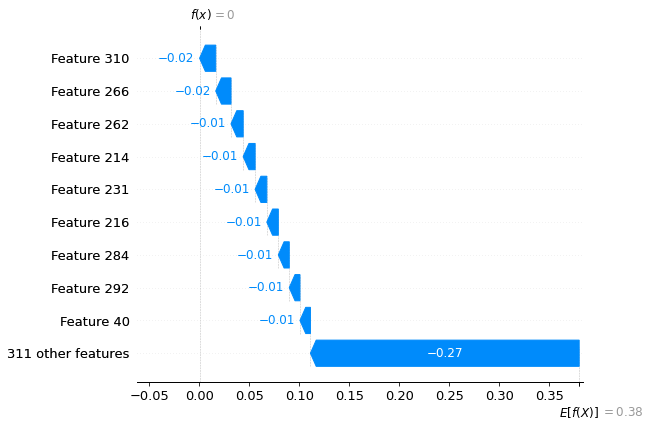

In [ ]:
# https://stackoverflow.com/questions/65029216/how-to-interpret-base-value-of-multi-class-classification-problem-when-using-sha/65034362#65034362
from shap import Explanation
shap.waterfall_plot(Explanation(shap_values[0][0],explainer.expected_value[0]))

In [ ]:
# shap values are one for each instance of the test set. each shap value has a contributio for each feature into the final classification, but it's not yet clear how the contribution  summed together generates the class to classify / how is the contribution for eahc class
pd.DataFrame(shap_values[0]).describe()

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,...,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,-0.000468,0.000098,-0.000149,0.000155,-0.000249,-0.000604,-0.000516,-0.001201,0.000281,-0.000339,...,-0.009001,-0.006342,-0.000245,-0.000531,-0.000752,-0.001368,-0.000713,-0.000612,-0.000097,-0.000012
std,0.003301,0.003940,0.002934,0.002976,0.003884,0.003426,0.003447,0.004881,0.003253,0.003313,...,0.014204,0.010807,0.003442,0.004044,0.003403,0.003280,0.003536,0.006137,0.003629,0.003343
min,-0.015576,-0.010951,-0.008461,-0.009808,-0.009927,-0.012965,-0.008091,-0.014983,-0.013412,-0.010984,...,-0.034924,-0.028814,-0.014062,-0.014602,-0.010035,-0.012934,-0.015776,-0.013875,-0.013081,-0.012539
25%,-0.002067,-0.001858,-0.001444,-0.001266,-0.002788,-0.002997,-0.002797,-0.004175,-0.000217,-0.001962,...,-0.019351,-0.013423,-0.001631,-0.002769,-0.002386,-0.003188,-0.002182,-0.004076,-0.001786,-0.001603
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001927,0.000000,0.000000,...,-0.012465,-0.008128,0.000000,-0.000093,0.000000,0.000000,0.000000,-0.001376,0.000000,0.000000
75%,0.000563,0.001680,0.001142,0.001759,0.001327,0.000307,0.000904,0.001704,0.000697,0.001324,...,0.000000,-0.003148,0.001253,0.001433,0.000000,0.000000,0.000668,0.000000,0.001633,0.001787
max,0.008011,0.016404,0.009154,0.010789,0.017042,0.009637,0.011383,0.011817,0.011003,0.010688,...,0.027228,0.024107,0.011775,0.012346,0.014702,0.006131,0.008999,0.026091,0.012107,0.009141


In [ ]:
# vals= np.abs(shap_values).mean(0)
shap_abs = np.abs(shap_values)
k = shap_abs.mean(1)
feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(k))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(100)

,col_name,feature_importance_vals
295,PGR,0.083696
32,KRT14,0.077385
248,TPRG1,0.066738
231,GREB1,0.047959
10,CAPN8,0.047223
...,...,...
203,ANKRD30A,0.013764
215,SUSD3,0.013756
255,HPX,0.013581
151,TPX2,0.013581


In [ ]:
# uncomment to save feature importances
# feature_importance.to_excel(path+'shap/feature_importance_scores.xlsx')

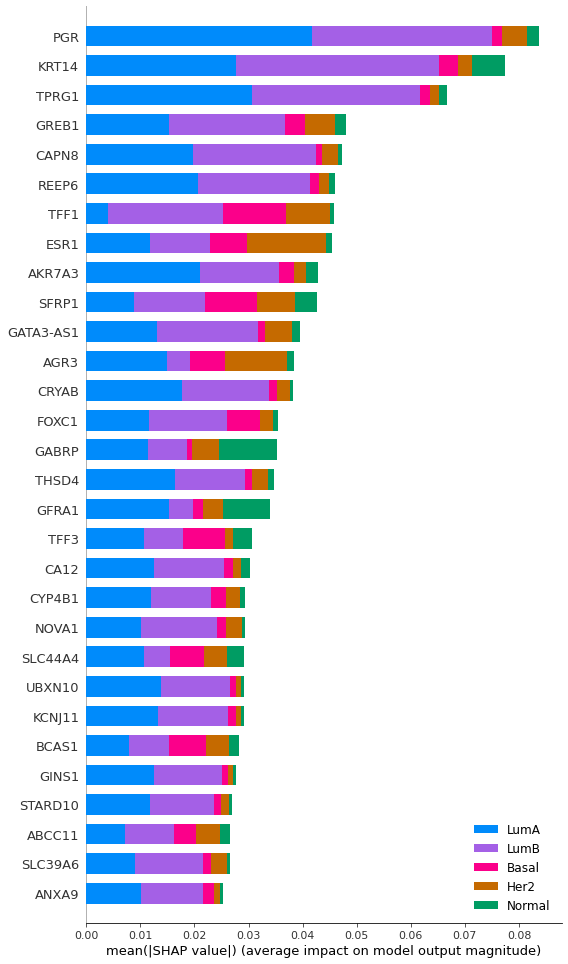

,col_name,feature_importance_vals
295,PGR,2.125889
32,KRT14,1.965576
248,TPRG1,1.695155
231,GREB1,1.218166
10,CAPN8,1.199470
...,...,...
203,ANKRD30A,0.349615
215,SUSD3,0.349395
255,HPX,0.344956
151,TPX2,0.344952


In [ ]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_train.columns, max_display=30, class_names= np.unique(SVC_trained.classes_))

### Overlap Analysis among different Feature Spaces

In [ ]:
# Now check how many of the selected features is in either pam50 or limma50 feature space

print("Total number of mrmr features: ", len(mrmr_features), "\n")

# pam50 features
pam50_feats = X_train_pam.columns
print("Total number of pam50 features: ", len(pam50_feats))
print("Total number of selected features with mrmr: ", len(mrmr_features))
print("Number of features from pam50 feature space which were selected with lasso selection: ", len(set(pam50_feats).intersection(selected_feat)))
print("Number of common features between pam50 and mrmr:", len(set(pam50_feats).intersection(mrmr_features)), "\n")

# limma50 features
limma50_feats = X_train_limma.columns
print("Total number of limma50 features: ", len(limma50_feats))
print("Total number of selected features with mrmr: ", len(mrmr_features))
print("Number of features from limma50 feature space which were selected with lasso selection: ", len(set(limma50_feats).intersection(selected_feat)))
print("Number of common features between limma50 and mrmr:", len(set(limma50_feats).intersection(mrmr_features)), "\n")

# mrmr and lasso
print("Total number of selected features with lasso: ", len(selected_feat))
print("Number of common features between lasso and mrmr:", len(set(selected_feat).intersection(mrmr_features)), "\n")

# Combinations
print("Number of features from limma50 and pam50 feature spaces which were selected with lasso selection: ", len(pam50_feats.intersection(limma50_feats.intersection(selected_feat))) )
print("Number of common features between limma50, pam50 and mrmrset: ", len(set(pam50_feats.intersection(limma50_feats.intersection(selected_feat))).intersection(mrmr_features) ))

In [ ]:
# Now check how many of the selected features is in either pam50 or limma50 feature space

print("FISHER SCORE FEATURE SPACE THRESHOLD AT 98% of scores")
# pam50 features
pam50_feats = X_train_pam.columns
print("Total number of pam50 features: ",len(pam50_feats))
print("Total number of selected features with Fisher score: ",len(X_train_fisher.columns))
i = 0
for p in pam50_feats:
  if p in X_train_fisher.columns:
    i+=1

print("Number of features from pam50 feature space which were selected with Fisher score: ", i)

# limma50 features
limma50_feats = X_train_limma.columns
print("Total number of limma50 features: ",len(limma50_feats))
print("Total number of selected features with Fisher score: ",len(X_train_fisher.columns))
j = 0
for p in limma50_feats:
  if p in X_train_fisher.columns:
    j+=1

print("Number of features from limma50 feature space which were selected with Fisher score: ", j)

print("Number of features from limma50 and pam50 feature spaces which were selected with Fisher score selection: ",len(pam50_feats.intersection(limma50_feats.intersection(X_train_fisher.columns))) )

FISHER SCORE FEATURE SPACE THRESHOLD AT 98% of scores
Total number of pam50 features:  49
Total number of selected features with Fisher score:  372
Number of features from pam50 feature space which were selected with Fisher score:  0
Total number of limma50 features:  185
Total number of selected features with Fisher score:  372
Number of features from limma50 feature space which were selected with Fisher score:  2
Number of features from limma50 and pam50 feature spaces which were selected with Fisher score selection:  0


#### *Mutual Information feature space exploration and comparison with fs filtered with pam50 and limma50:*

In [ ]:
# Now check how many of the selected features is in either pam50 or limma50 feature space
print("MUTUAL INFO FEATURE SPACE THRESHOLD AT 98% of scores")
# pam50 features
pam50_feats = X_train_pam.columns
print("Total number of pam50 features: ",len(pam50_feats))
print("Total number of selected features with mutual info: ",len(X_train_mi.columns))
i = 0
for p in pam50_feats:
  if p in X_train_mi.columns:
    i+=1

print("Number of features from pam50 feature space which were selected with mutual info: ", i)

# limma50 features
limma50_feats = X_train_limma.columns
print("Total number of limma50 features: ",len(limma50_feats))
print("Total number of selected features with mutual info: ",len(X_train_mi.columns))
j = 0
for p in limma50_feats:
  if p in X_train_mi.columns:
    j+=1

print("Number of features from limma50 feature space which were selected with mutual info: ", j)

print("Number of features from limma50 and pam50 feature spaces which were selected with mutual info selection: ",len(pam50_feats.intersection(limma50_feats.intersection(X_train_mi.columns))) )

MUTUAL INFO FEATURE SPACE THRESHOLD AT 98% of scores
Total number of pam50 features:  49
Total number of selected features with mutual info:  373
Number of features from pam50 feature space which were selected with mutual info:  36
Total number of limma50 features:  185
Total number of selected features with mutual info:  373
Number of features from limma50 feature space which were selected with mutual info:  119
Number of features from limma50 and pam50 feature spaces which were selected with mutual info selection:  25


In [ ]:
def show_single_class_evaluation(y_pred: int, y_test: int, labels):
  print("Balanced accuracy: ", round(balanced_accuracy_score(y_test, y_pred), 3)) # not possible for single class
  print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3)) # not possible for single class
  print('precision ', round(precision_score(y_test, y_pred, average="macro"), 3))
  print('recall ', round(recall_score(y_test, y_pred, average="macro"), 3))
  print('f1_macro ', round(f1_score(y_test, y_pred, average="macro"),3))
  print('f1_micro ', round(f1_score(y_test, y_pred, average="micro"),3))
  print("Precision: ", [round(i, 3) for i in precision_score(y_test, y_pred, average=None) ])
  print("Recall: ",  [round(i, 3) for i in recall_score(y_test, y_pred, average=None) ]) 
  print("F1 Score: ", [round(i, 3) for i in f1_score(y_test, y_pred, average=None) ]) 
  print('--------------------------------------------')

  dic_result = {}
  dic_result['balanced_accuracy'] = [round(balanced_accuracy_score(y_test, y_pred), 3)]
  dic_result['accuracy'] = [round(accuracy_score(y_test, y_pred), 3)]
  for i in range(len(labels)):
    dic_result[labels[i]+'-precision'] =  round( precision_score(y_test, y_pred, average=None)[i], 3)
  for i in range(len(labels)):
    dic_result[labels[i]+'-recall'] =  round( recall_score(y_test, y_pred, average=None)[i], 3)
  for i in range(len(labels)):   
    dic_result[labels[i]+'-f1_score'] =  round( f1_score(y_test, y_pred, average=None)[i], 3)
  
  df_result = pd.DataFrame.from_dict(dic_result)
  df_result.to_excel('output_detailed_scores.xlsx')
  print(df_result)

In [ ]:
def create_evaluation( y_pred: int, y_test: int, labels, name):

  return [ name,
          round(balanced_accuracy_score(y_test, y_pred), 3), 
          round(accuracy_score(y_test, y_pred), 3),
          round(precision_score(y_test, y_pred, average="macro"), 3),
          round(f1_score(y_test, y_pred, average="macro"),3),
          round(recall_score(y_test, y_pred, average="macro"), 3),
          round(f1_score(y_test, y_pred, average="micro"),3)]

#### Genes overlapping between all feature spaces

In [ ]:
 # https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
all_X_train = [  X_train_lasso, X_train_mrmr,X_train_mrmr_350 ,X_train_mrmr_250, X_train_mrmr_150, X_train_pam_log2,X_train_pam_sbf, X_train_limma_log2, X_train_limma_sbf,X_train_fisher_99, X_train_fisher_sbf_99,X_train_fisher_98, X_train_fisher_sbf_98, X_train_fisher, X_train_fisher_sbf,X_train_mi_99, X_train_mi_sbf_99,X_train_mi_98, X_train_mi_sbf_98,X_train_mi, X_train_mi_sbf, X_train_mi_92, X_train_mi_sbf_92,] #mrmr msising
all_Y_train = [ Y_train_pam_log2, Y_train_limma_log2,  Y_train_lasso, Y_train_fisher,Y_train_mi ] #mrmr msising


all_X_test = [ X_test_pam_log2, X_test_limma_log2, X_test_lasso,X_test_fisher,X_test_mi ] #mrmr msising
all_Y_test = [ Y_test_pam_log2,Y_test_limma_log2, Y_test_lasso,Y_test_fisher,Y_test_mi ] #mrmr msising

feature_spaces_names = [ 'full_lasso', 'mrmr750_from_12kf','mrmr350','mrmr250','mrmr150', 'pam_log2',  'sbf_pam','limma_log2', 'sbf_limma', 'fisher99', 'sbf_fisher99','fisher98', 'sbf_fisher98','fisher97', 'sbf_fisher97', 'mi99',  'sbf_mi99', 'mi98',  'sbf_mi98', 'mi97',  'sbf_mi97',  'mi92',  'sbf_mi92'] #mrmr

['LumA' 'Basal' 'LumB' 'Normal' 'Her2']


In [ ]:
all_X_train = all_X_train + X_train_randoms
feature_spaces_names = feature_spaces_names + random_spaces_names

In [ ]:
dic_intersect = {}
for x, name in zip(all_X_train, feature_spaces_names):
  dic_intersect[name]= []
  for y in all_X_train:
    dic_intersect[name].append(len(set(x).intersection(y)))
  
  print(f"Number of isforms intersected with the others in feature space : {name} is { dic_intersect[name]}")

Number of isforms intersected with the others in feature space : full_lasso is [977, 243, 136, 114, 79, 34, 29, 99, 73, 2, 2, 3, 2, 4, 3, 61, 57, 100, 84, 130, 114, 255, 209, 30, 28, 34, 23, 16, 27, 34, 28, 17, 30]
Number of isforms intersected with the others in feature space : mrmr750_from_12kf is [243, 750, 350, 250, 150, 44, 36, 168, 140, 2, 1, 4, 3, 6, 5, 122, 114, 242, 206, 345, 296, 630, 430, 23, 16, 24, 21, 22, 16, 20, 22, 15, 13]
Number of isforms intersected with the others in feature space : mrmr350 is [136, 350, 350, 250, 150, 33, 26, 137, 111, 2, 1, 4, 3, 4, 3, 116, 109, 214, 180, 267, 227, 327, 224, 9, 9, 14, 9, 9, 8, 9, 9, 6, 3]
Number of isforms intersected with the others in feature space : mrmr250 is [114, 250, 250, 250, 150, 32, 26, 126, 100, 0, 0, 2, 2, 2, 2, 111, 104, 181, 151, 209, 180, 241, 175, 6, 7, 12, 6, 6, 6, 5, 5, 5, 1]
Number of isforms intersected with the others in feature space : mrmr150 is [79, 150, 150, 150, 150, 23, 20, 94, 73, 0, 0, 1, 1, 1, 1, 92, 

In [ ]:
df_inters = pd.DataFrame.from_dict(dic_intersect, orient='index', columns=feature_spaces_names)
# df_inters.to_excel(path+"genes_intersect_2401.xlsx")

In [ ]:
df_inters_withpercent = df_inters * 1000 / 12381
# df_inters_withpercent.to_excel(path+"genes_intersect_2401_withpercent.xlsx")

In [ ]:
# create the upper triangular mask for first dataframe
upper_tri_mask = np.triu(np.ones(df_inters.shape), k=1)

# create the lower triangular mask for the second dataframe
lower_tri_mask = np.tril(np.ones(df_inters_withpercent.shape), k=-1)

diag_mask = np.eye(df_inters.shape[0], dtype=bool)

# create the new dataframe by using the mask to select the values from df1 and df2
result = pd.DataFrame(np.where(upper_tri_mask, df_inters, np.where(lower_tri_mask,  df_inters_withpercent, df_inters[diag_mask].astype(str) + '|' + df_inters_withpercent[diag_mask].astype(str))),columns=df_inters.columns)

# update the diagonal with a custom string
# result[diag_mask] = df_inters[diag_mask].astype(str) + '|' + df_inters_withpercent[diag_mask].astype(str)

result
# result.to_excel(path+"genes_intersect_2801_withdiagonal.xlsx")